<a href="https://colab.research.google.com/github/gabillah/optimization/blob/main/NSGA%202%20-%2006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

                  NSGA-II PROPELLER-ENGINE OPTIMIZATION SYSTEM                  

Starting NSGA-II optimization...
Initializing population...
Generation 10/100 - Pareto Front Size: 27
Generation 20/100 - Pareto Front Size: 101
Generation 30/100 - Pareto Front Size: 127
Generation 40/100 - Pareto Front Size: 125
Generation 50/100 - Pareto Front Size: 127
Generation 60/100 - Pareto Front Size: 134
Generation 70/100 - Pareto Front Size: 128
Generation 80/100 - Pareto Front Size: 128
Generation 90/100 - Pareto Front Size: 132
Generation 100/100 - Pareto Front Size: 130

Optimization complete!
Total Pareto solutions: 100
Feasible solutions: 100

                   OPTIMUM PROPELLER-ENGINE MATCHING SOLUTION                   

--- SHIP OPERATING CONDITIONS ---
Ship Speed (Vs)         : 10.00 knots
Hull Resistance         : 187.93 kN

--- PROPELLER DESIGN ---
Diameter (D)            : 4.50 m
RPM (n)                 : 80.0 rpm
Pitch Ratio (P/D)       : 0.945
Expanded Area Ratio (EAR): 0.400
Nu

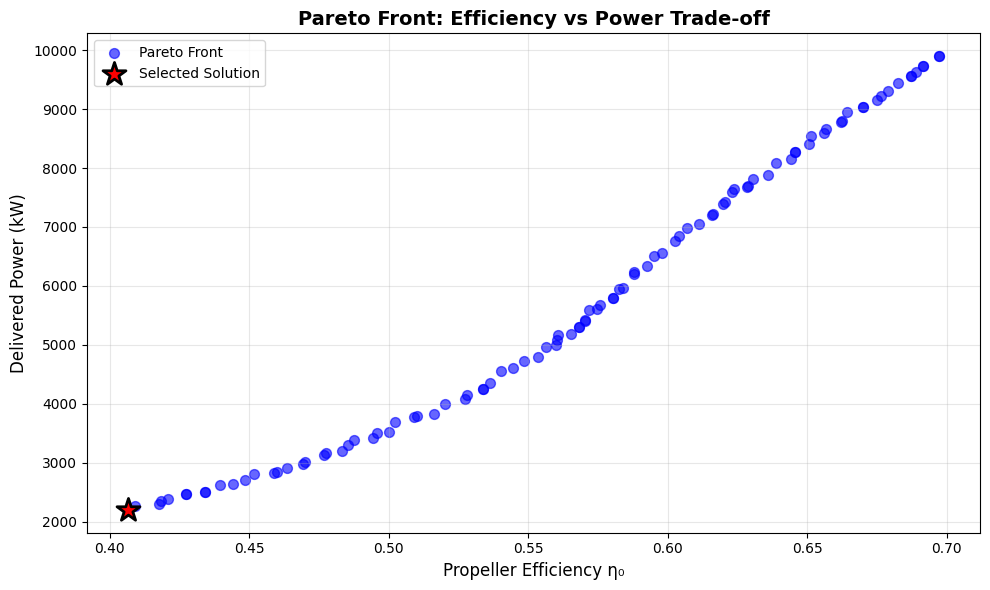

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Dict
import copy
from dataclasses import dataclass

# ============================================================================
# SECTION 1: DATA STRUCTURES & FIXED PARAMETERS
# ============================================================================

@dataclass
class FixedParameters:
    """Parameter tetap yang tidak bisa dirubah"""
    # Hull characteristics
    ship_length: float = 100.0  # m
    ship_beam: float = 15.0     # m
    ship_draft: float = 6.0     # m
    displacement: float = 5000.0 # ton

    # Hull factors
    t: float = 0.18  # thrust deduction factor
    w: float = 0.25  # wake fraction

    # Propeller fixed
    D: float = 4.5   # diameter propeller (m)

    # Water properties
    rho: float = 1025.0  # kg/m³
    rho_vapor: float = 1700.0  # Pa (vapor pressure)
    g: float = 9.81  # m/s²
    nu: float = 1.19e-6  # kinematic viscosity m²/s

    # Engine/Gearbox margins
    sea_margin: float = 0.15  # 15%
    shaft_efficiency: float = 0.97

    def hull_resistance(self, Vs: float) -> float:
        """Fungsi tahanan lambung (simplified Holtrop-Mennen)"""
        Fn = Vs * 0.5144 / np.sqrt(self.g * self.ship_length)  # knots to m/s
        Cf = 0.075 / ((np.log10(self.ship_length * Vs * 0.5144 / self.nu) - 2) ** 2)

        S_wetted = 1.7 * self.ship_length * self.ship_draft + \
                   self.ship_beam * self.ship_draft

        Rv = 0.5 * self.rho * (Vs * 0.5144) ** 2 * S_wetted * Cf
        Rw = 0.5 * self.rho * self.g * (Vs * 0.5144) ** 2 * \
             S_wetted * 0.001 * np.exp(3.5 * Fn ** 2)

        return Rv + Rw  # N

@dataclass
class Individual:
    """Representasi individu dalam populasi GA"""
    # Design variables (genes)
    Vs: float      # ship speed (knots)
    n: float       # propeller RPM
    P_D: float     # Pitch/Diameter ratio
    EAR: float     # Expanded Area Ratio
    Z: int         # number of blades

    # Calculated values
    J: float = 0.0
    KT: float = 0.0
    KQ: float = 0.0
    T: float = 0.0
    Q: float = 0.0
    eta_prop: float = 0.0
    Pd: float = 0.0

    # Objectives
    f1: float = 0.0  # efficiency (maximize -> minimize negative)
    f2: float = 0.0  # power (minimize)

    # Constraints violation
    violation: float = 0.0

    # NSGA-II attributes
    rank: int = 0
    crowding_distance: float = 0.0
    dominated_solutions: List = None
    domination_count: int = 0

    def __post_init__(self):
        if self.dominated_solutions is None:
            self.dominated_solutions = []

# ============================================================================
# SECTION 2: B-SERIES PROPELLER REGRESSION (SURROGATE MODEL)
# ============================================================================

class BSeriesRegression:
    """B-Series polynomial regression untuk KT dan KQ"""

    def __init__(self):
        # Coefficients untuk KT (simplified, 10 terms)
        self.KT_coeffs = np.array([
            [0.00880496, -0.204554, 0.166351, 0.158114],
            [0.00880496, -0.204554, 0.166351, 0.158114],
            [-0.0108009, 0.0885381, -0.137302, 0],
            [-0.0108009, 0.0885381, -0.137302, 0],
            [0.0344415, -0.0588710, 0, 0.0307699]
        ])

        # Coefficients untuk KQ (simplified, 10 terms)
        self.KQ_coeffs = np.array([
            [0.00379368, -0.0403520, 0.0407026, 0.0435749],
            [0.00379368, -0.0403520, 0.0407026, 0.0435749],
            [-0.00206450, 0.0128560, -0.0269403, 0],
            [-0.00206450, 0.0128560, -0.0269403, 0],
            [0.00623240, -0.00723450, 0, 0.00597620]
        ])

    def calculate_KT(self, J: float, P_D: float, EAR: float, Z: int) -> float:
        """Calculate thrust coefficient KT"""
        KT = 0.0
        for i, row in enumerate(self.KT_coeffs):
            for j, coeff in enumerate(row):
                KT += coeff * (J ** i) * (P_D ** j) * (EAR ** (j % 2)) * (Z ** 0.5)
        return max(0.001, KT)  # prevent negative

    def calculate_KQ(self, J: float, P_D: float, EAR: float, Z: int) -> float:
        """Calculate torque coefficient KQ"""
        KQ = 0.0
        for i, row in enumerate(self.KQ_coeffs):
            for j, coeff in enumerate(row):
                KQ += coeff * (J ** i) * (P_D ** j) * (EAR ** (j % 2)) * (Z ** 0.3)
        return max(0.0001, KQ)  # prevent negative

# ============================================================================
# SECTION 3: CONSTRAINT CHECKING
# ============================================================================

class ConstraintChecker:
    """Check semua constraint"""

    @staticmethod
    def check_thrust_balance(T_prop: float, R_hull: float, t: float) -> float:
        """Constraint 1: Thrust identity"""
        required_thrust = R_hull / (1 - t)
        violation = max(0, required_thrust - T_prop)
        return violation

    @staticmethod
    def check_cavitation_burrill(T: float, n: float, D: float,
                                  EAR: float, z: int,
                                  rho: float, h: float,
                                  rho_vapor: float) -> float:
        """Constraint 2: Burrill cavitation criteria"""
        # Burrill criterion: tau_c = T / (0.5 * rho * (n*D)^2 * Ap)
        Ap = (np.pi * D ** 2 / 4) * EAR  # projected area

        if Ap <= 0 or n <= 0:
            return 1e6  # large penalty

        tau_c = T / (0.5 * rho * (n / 60) ** 2 * D ** 2 * Ap)

        # Static pressure at propeller center
        P_static = rho * 9.81 * h + 101325  # Pa

        # Cavitation number
        sigma = (P_static - rho_vapor) / (0.5 * rho * (n * D / 60) ** 2)

        # Burrill limit
        tau_limit = 0.2 + 0.8 * sigma

        violation = max(0, tau_c - tau_limit)
        return violation

# ============================================================================
# SECTION 4: EVALUATION FUNCTION
# ============================================================================

class PropellerEvaluator:
    """Evaluate individual fitness"""

    def __init__(self, fixed_params: FixedParameters):
        self.fp = fixed_params
        self.b_series = BSeriesRegression()
        self.constraint_checker = ConstraintChecker()

    def evaluate(self, ind: Individual) -> Individual:
        """Main evaluation function"""
        # Step 1: Calculate advance coefficient J
        Va = ind.Vs * 0.5144 * (1 - self.fp.w)  # m/s
        ind.J = Va / (ind.n / 60 * self.fp.D)

        # Step 2: Calculate KT and KQ from B-Series
        ind.KT = self.b_series.calculate_KT(ind.J, ind.P_D, ind.EAR, ind.Z)
        ind.KQ = self.b_series.calculate_KQ(ind.J, ind.P_D, ind.EAR, ind.Z)

        # Step 3: Calculate Thrust and Torque
        n_rps = ind.n / 60
        ind.T = ind.KT * self.fp.rho * (n_rps ** 2) * (self.fp.D ** 4)
        ind.Q = ind.KQ * self.fp.rho * (n_rps ** 2) * (self.fp.D ** 5)

        # Step 4: Calculate efficiency
        if ind.Q > 0 and ind.n > 0:
            ind.eta_prop = (ind.T * Va) / (2 * np.pi * n_rps * ind.Q)
        else:
            ind.eta_prop = 0.0

        # Step 5: Calculate delivered power
        ind.Pd = 2 * np.pi * n_rps * ind.Q / 1000  # kW

        # Step 6: Check constraints
        R_hull = self.fp.hull_resistance(ind.Vs)

        violation_thrust = self.constraint_checker.check_thrust_balance(
            ind.T, R_hull, self.fp.t
        )

        violation_cavitation = self.constraint_checker.check_cavitation_burrill(
            ind.T, ind.n, self.fp.D, ind.EAR, ind.Z,
            self.fp.rho, self.fp.ship_draft * 0.75, self.fp.rho_vapor
        )

        ind.violation = violation_thrust + violation_cavitation * 1e-3

        # Step 7: Calculate objectives
        # f1: maximize efficiency -> minimize (-efficiency)
        # f2: minimize power

        if ind.violation > 0:
            # Apply penalty
            penalty = 1e6 * ind.violation
            ind.f1 = -ind.eta_prop + penalty
            ind.f2 = ind.Pd + penalty
        else:
            ind.f1 = -ind.eta_prop  # negative for maximization
            ind.f2 = ind.Pd

        return ind

# ============================================================================
# SECTION 5: NSGA-II ALGORITHM
# ============================================================================

class NSGA2:
    """NSGA-II Multi-objective optimization"""

    def __init__(self,
                 pop_size: int = 100,
                 max_gen: int = 100,
                 crossover_prob: float = 0.9,
                 mutation_prob: float = 0.1,
                 fixed_params: FixedParameters = None):

        self.pop_size = pop_size
        self.max_gen = max_gen
        self.crossover_prob = crossover_prob
        self.mutation_prob = mutation_prob
        self.fp = fixed_params or FixedParameters()
        self.evaluator = PropellerEvaluator(self.fp)

        # Design space bounds
        self.bounds = {
            'Vs': (10.0, 20.0),      # knots
            'n': (80.0, 200.0),      # RPM
            'P_D': (0.6, 1.4),       # pitch ratio
            'EAR': (0.4, 1.0),       # expanded area ratio
            'Z': (3, 5)              # blades (integer)
        }

    def initialize_population(self) -> List[Individual]:
        """Generate random initial population"""
        population = []
        for _ in range(self.pop_size):
            ind = Individual(
                Vs=np.random.uniform(*self.bounds['Vs']),
                n=np.random.uniform(*self.bounds['n']),
                P_D=np.random.uniform(*self.bounds['P_D']),
                EAR=np.random.uniform(*self.bounds['EAR']),
                Z=np.random.randint(*self.bounds['Z'])
            )
            ind = self.evaluator.evaluate(ind)
            population.append(ind)
        return population

    def dominates(self, ind1: Individual, ind2: Individual) -> bool:
        """Check if ind1 dominates ind2 (Pareto dominance)"""
        better_in_one = False
        for obj1, obj2 in [(ind1.f1, ind2.f1), (ind1.f2, ind2.f2)]:
            if obj1 > obj2:
                return False
            if obj1 < obj2:
                better_in_one = True
        return better_in_one

    def fast_non_dominated_sort(self, population: List[Individual]) -> List[List[Individual]]:
        """Non-dominated sorting"""
        fronts = [[]]

        for p in population:
            p.dominated_solutions = []
            p.domination_count = 0

            for q in population:
                if self.dominates(p, q):
                    p.dominated_solutions.append(q)
                elif self.dominates(q, p):
                    p.domination_count += 1

            if p.domination_count == 0:
                p.rank = 0
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in p.dominated_solutions:
                    q.domination_count -= 1
                    if q.domination_count == 0:
                        q.rank = i + 1
                        next_front.append(q)
            i += 1
            if next_front:
                fronts.append(next_front)
            else:
                break

        return fronts

    def calculate_crowding_distance(self, front: List[Individual]):
        """Calculate crowding distance for a front"""
        if len(front) == 0:
            return

        for ind in front:
            ind.crowding_distance = 0

        # For each objective
        for m in ['f1', 'f2']:
            front.sort(key=lambda x: getattr(x, m))

            front[0].crowding_distance = float('inf')
            front[-1].crowding_distance = float('inf')

            obj_min = getattr(front[0], m)
            obj_max = getattr(front[-1], m)
            obj_range = obj_max - obj_min

            if obj_range == 0:
                continue

            for i in range(1, len(front) - 1):
                front[i].crowding_distance += \
                    (getattr(front[i + 1], m) - getattr(front[i - 1], m)) / obj_range

    def tournament_selection(self, population: List[Individual]) -> Individual:
        """Binary tournament selection"""
        i1, i2 = np.random.choice(len(population), 2, replace=False)
        ind1, ind2 = population[i1], population[i2]

        if ind1.rank < ind2.rank:
            return copy.deepcopy(ind1)
        elif ind1.rank > ind2.rank:
            return copy.deepcopy(ind2)
        else:
            if ind1.crowding_distance > ind2.crowding_distance:
                return copy.deepcopy(ind1)
            else:
                return copy.deepcopy(ind2)

    def sbx_crossover(self, parent1: Individual, parent2: Individual) -> Tuple[Individual, Individual]:
        """Simulated Binary Crossover (SBX)"""
        child1 = copy.deepcopy(parent1)
        child2 = copy.deepcopy(parent2)

        if np.random.random() > self.crossover_prob:
            return child1, child2

        eta_c = 20  # distribution index

        for attr in ['Vs', 'n', 'P_D', 'EAR']:
            if np.random.random() < 0.5:
                val1 = getattr(parent1, attr)
                val2 = getattr(parent2, attr)

                beta = np.random.random()
                if beta <= 0.5:
                    beta_q = (2 * beta) ** (1 / (eta_c + 1))
                else:
                    beta_q = (1 / (2 * (1 - beta))) ** (1 / (eta_c + 1))

                c1 = 0.5 * ((val1 + val2) - beta_q * abs(val2 - val1))
                c2 = 0.5 * ((val1 + val2) + beta_q * abs(val2 - val1))

                # Ensure bounds
                lb, ub = self.bounds[attr]
                c1 = np.clip(c1, lb, ub)
                c2 = np.clip(c2, lb, ub)

                setattr(child1, attr, c1)
                setattr(child2, attr, c2)

        # Integer crossover for Z
        if np.random.random() < 0.5:
            child1.Z, child2.Z = parent2.Z, parent1.Z

        return child1, child2

    def polynomial_mutation(self, individual: Individual) -> Individual:
        """Polynomial mutation"""
        eta_m = 20  # distribution index

        for attr in ['Vs', 'n', 'P_D', 'EAR']:
            if np.random.random() < self.mutation_prob:
                val = getattr(individual, attr)
                lb, ub = self.bounds[attr]

                delta = (ub - lb)
                u = np.random.random()

                if u < 0.5:
                    delta_q = (2 * u) ** (1 / (eta_m + 1)) - 1
                else:
                    delta_q = 1 - (2 * (1 - u)) ** (1 / (eta_m + 1))

                val = val + delta_q * delta
                val = np.clip(val, lb, ub)
                setattr(individual, attr, val)

        # Integer mutation for Z
        if np.random.random() < self.mutation_prob:
            individual.Z = np.random.randint(*self.bounds['Z'])

        return individual

    def evolve(self) -> Tuple[List[Individual], List[List[Individual]]]:
        """Main evolution loop"""
        print("Initializing population...")
        population = self.initialize_population()

        history = []

        for gen in range(self.max_gen):
            # Generate offspring
            offspring = []
            for _ in range(self.pop_size // 2):
                parent1 = self.tournament_selection(population)
                parent2 = self.tournament_selection(population)

                child1, child2 = self.sbx_crossover(parent1, parent2)

                child1 = self.polynomial_mutation(child1)
                child2 = self.polynomial_mutation(child2)

                child1 = self.evaluator.evaluate(child1)
                child2 = self.evaluator.evaluate(child2)

                offspring.extend([child1, child2])

            # Combine parent and offspring
            combined = population + offspring

            # Non-dominated sorting
            fronts = self.fast_non_dominated_sort(combined)

            # Calculate crowding distance
            for front in fronts:
                self.calculate_crowding_distance(front)

            # Select next generation
            new_population = []
            for front in fronts:
                if len(new_population) + len(front) <= self.pop_size:
                    new_population.extend(front)
                else:
                    front.sort(key=lambda x: x.crowding_distance, reverse=True)
                    new_population.extend(front[:self.pop_size - len(new_population)])
                    break

            population = new_population
            history.append(fronts)

            # Print progress
            if (gen + 1) % 10 == 0:
                print(f"Generation {gen + 1}/{self.max_gen} - Pareto Front Size: {len(fronts[0])}")

        return population, history

# ============================================================================
# SECTION 6: POST-PROCESSING & ENGINE MATCHING
# ============================================================================

class EngineDatabase:
    """Simplified engine database"""

    def __init__(self):
        self.engines = [
            {'name': 'MAN 6L21/31', 'MCR_kW': 1080, 'rpm': 900, 'weight_ton': 4.5},
            {'name': 'MAN 8L21/31', 'MCR_kW': 1440, 'rpm': 900, 'weight_ton': 5.8},
            {'name': 'MAN 6L27/38', 'MCR_kW': 1620, 'rpm': 750, 'weight_ton': 8.2},
            {'name': 'Wartsila 6L20', 'MCR_kW': 1320, 'rpm': 900, 'weight_ton': 5.5},
            {'name': 'Caterpillar 3512C', 'MCR_kW': 1470, 'rpm': 1800, 'weight_ton': 6.8},
            {'name': 'Yanmar 6EY22', 'MCR_kW': 1620, 'rpm': 750, 'weight_ton': 9.5},
        ]

        self.gearbox_ratios = [1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.0]

    def find_suitable_engine(self, PB_required: float, n_prop: float) -> Dict:
        """Find suitable engine and gearbox combination"""
        candidates = []

        for engine in self.engines:
            if engine['MCR_kW'] >= PB_required:
                for ratio in self.gearbox_ratios:
                    n_engine = n_prop * ratio
                    if abs(n_engine - engine['rpm']) / engine['rpm'] < 0.15:
                        candidates.append({
                            'engine': engine,
                            'gearbox_ratio': ratio,
                            'n_engine': n_engine,
                            'efficiency': 1.0 - abs(n_engine - engine['rpm']) / engine['rpm']
                        })

        if candidates:
            return max(candidates, key=lambda x: x['efficiency'])
        return None

def select_best_solution(pareto_front: List[Individual],
                        method: str = 'knee') -> Individual:
    """Select single best solution from Pareto front"""

    if method == 'knee':
        # Knee point method - find point with max distance from line
        if len(pareto_front) < 2:
            return pareto_front[0]

        # Normalize objectives
        f1_values = np.array([-ind.f1 for ind in pareto_front])  # convert back to positive
        f2_values = np.array([ind.f2 for ind in pareto_front])

        f1_norm = (f1_values - f1_values.min()) / (f1_values.max() - f1_values.min() + 1e-10)
        f2_norm = (f2_values - f2_values.min()) / (f2_values.max() - f2_values.min() + 1e-10)

        # Find knee point
        distances = np.sqrt(f1_norm ** 2 + f2_norm ** 2)
        knee_idx = np.argmin(distances)

        return pareto_front[knee_idx]

    elif method == 'topsis':
        # TOPSIS method - simplified
        weights = np.array([0.6, 0.4])  # 60% efficiency, 40% power

        f1_values = np.array([-ind.f1 for ind in pareto_front])
        f2_values = np.array([ind.f2 for ind in pareto_front])

        # Normalize
        decision_matrix = np.column_stack([f1_values, f2_values])
        norm_matrix = decision_matrix / np.sqrt((decision_matrix ** 2).sum(axis=0))

        # Weighted matrix
        weighted_matrix = norm_matrix * weights

        # Ideal solutions
        ideal_best = weighted_matrix.max(axis=0)
        ideal_worst = weighted_matrix.min(axis=0)

        # Distance to ideal
        dist_best = np.sqrt(((weighted_matrix - ideal_best) ** 2).sum(axis=1))
        dist_worst = np.sqrt(((weighted_matrix - ideal_worst) ** 2).sum(axis=1))

        # Performance score
        scores = dist_worst / (dist_best + dist_worst + 1e-10)
        best_idx = np.argmax(scores)

        return pareto_front[best_idx]

# ============================================================================
# SECTION 7: VISUALIZATION
# ============================================================================

def plot_pareto_front(pareto_front: List[Individual], selected: Individual = None):
    """Plot Pareto front"""
    f1_values = [-ind.f1 for ind in pareto_front]  # efficiency (positive)
    f2_values = [ind.f2 for ind in pareto_front]    # power

    plt.figure(figsize=(10, 6))
    plt.scatter(f1_values, f2_values, c='blue', alpha=0.6, s=50, label='Pareto Front')

    if selected:
        plt.scatter(-selected.f1, selected.f2, c='red', marker='*', s=300,
                   label='Selected Solution', edgecolors='black', linewidths=2)

    plt.xlabel('Propeller Efficiency η₀', fontsize=12)
    plt.ylabel('Delivered Power (kW)', fontsize=12)
    plt.title('Pareto Front: Efficiency vs Power Trade-off', fontsize=14, weight='bold')
    plt.grid(True, alpha=0.3)
    plt.legend()
    plt.tight_layout()
    plt.show()

def print_solution_report(individual: Individual, engine_match: Dict, fixed_params: FixedParameters):
    """Print detailed solution report"""
    print("\n" + "="*80)
    print("OPTIMUM PROPELLER-ENGINE MATCHING SOLUTION".center(80))
    print("="*80)

    print("\n--- SHIP OPERATING CONDITIONS ---")
    print(f"Ship Speed (Vs)         : {individual.Vs:.2f} knots")
    print(f"Hull Resistance         : {fixed_params.hull_resistance(individual.Vs)/1000:.2f} kN")

    print("\n--- PROPELLER DESIGN ---")
    print(f"Diameter (D)            : {fixed_params.D:.2f} m")
    print(f"RPM (n)                 : {individual.n:.1f} rpm")
    print(f"Pitch Ratio (P/D)       : {individual.P_D:.3f}")
    print(f"Expanded Area Ratio (EAR): {individual.EAR:.3f}")
    print(f"Number of Blades (Z)    : {individual.Z}")

    print("\n--- PROPELLER PERFORMANCE ---")
    print(f"Advance Coefficient (J) : {individual.J:.4f}")
    print(f"Thrust Coefficient (KT) : {individual.KT:.4f}")
    print(f"Torque Coefficient (KQ) : {individual.KQ:.5f}")
    print(f"Thrust Produced (T)     : {individual.T/1000:.2f} kN")
    print(f"Torque (Q)              : {individual.Q:.2f} Nm")
    print(f"Propeller Efficiency (η₀): {individual.eta_prop:.4f}")
    print(f"Delivered Power (Pd)    : {individual.Pd:.2f} kW")

    if engine_match:
        PB = individual.Pd / fixed_params.shaft_efficiency * (1 + fixed_params.sea_margin)
        print("\n--- ENGINE & GEARBOX MATCHING ---")
        print(f"Brake Power Required (PB): {PB:.2f} kW")
        print(f"Selected Engine         : {engine_match['engine']['name']}")
        print(f"Engine MCR              : {engine_match['engine']['MCR_kW']} kW")
        print(f"Engine RPM              : {engine_match['engine']['rpm']} rpm")
        print(f"Gearbox Ratio           : {engine_match['gearbox_ratio']:.2f}:1")
        print(f"Engine Load Factor      : {PB/engine_match['engine']['MCR_kW']*100:.1f}%")

    print("\n" + "="*80)

# ============================================================================
# SECTION 8: MAIN EXECUTION
# ============================================================================

def main():
    """Main execution function"""
    print("="*80)
    print("NSGA-II PROPELLER-ENGINE OPTIMIZATION SYSTEM".center(80))
    print("="*80)

    # Initialize parameters
    fixed_params = FixedParameters()

    # Create optimizer
    nsga2 = NSGA2(
        pop_size=100,
        max_gen=100,
        crossover_prob=0.9,
        mutation_prob=0.1,
        fixed_params=fixed_params
    )

    # Run optimization
    print("\nStarting NSGA-II optimization...")
    final_population, history = nsga2.evolve()

    # Extract Pareto front
    fronts = nsga2.fast_non_dominated_sort(final_population)
    pareto_front = fronts[0]

    # Filter valid solutions (no constraint violations)
    valid_solutions = [ind for ind in pareto_front if ind.violation < 1e-6]

    if not valid_solutions:
        print("\nWARNING: No feasible solutions found without constraint violations!")
        print("Using best solutions with minimum violations...")
        valid_solutions = sorted(pareto_front, key=lambda x: x.violation)[:10]

    print(f"\nOptimization complete!")
    print(f"Total Pareto solutions: {len(pareto_front)}")
    print(f"Feasible solutions: {len(valid_solutions)}")

    # Select best solution
    best_solution = select_best_solution(valid_solutions, method='knee')

    # Engine matching
    PB_required = best_solution.Pd / fixed_params.shaft_efficiency * \
                  (1 + fixed_params.sea_margin)

    engine_db = EngineDatabase()
    engine_match = engine_db.find_suitable_engine(PB_required, best_solution.n)

    # Print results
    print_solution_report(best_solution, engine_match, fixed_params)

    # Visualization
    plot_pareto_front(valid_solutions, best_solution)

    return best_solution, valid_solutions, engine_match

if __name__ == "__main__":
    best_solution, pareto_solutions, engine_match = main()